# Assignment 4
### Do three of six.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# %%

def download_data(force=False):
    """Download and extract course data from Zenodo."""
    import urllib.request
    import zipfile
    import os
    
    zip_path = 'data.zip'
    data_dir = 'data'
    
    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/16954427/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")
    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")
    
    return data_dir

download_data()

'data'

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [2]:
df = pd.read_csv('./data/mn_police_use_of_force.csv')
df['injury_missing'] = df['subject_injury'].isna() 
df['injury_missing']

0        True
1        True
2        True
3        True
4        True
         ... 
12920    True
12921    True
12922    True
12923    True
12924    True
Name: injury_missing, Length: 12925, dtype: bool

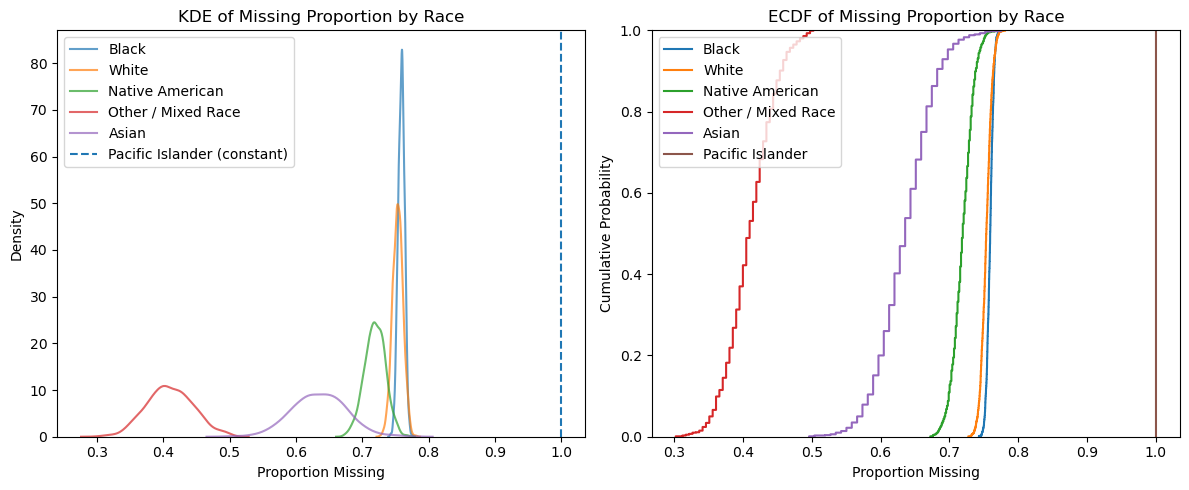

In [3]:
def stat(x):
    return x.isna().mean()

def simulate(var, df, fcn, S=1000):
    x = df[var]
    estimates = []
    for s in range(S):
        x_s = x.sample(frac=1.0, replace=True)
        stat_s = fcn(x_s)
        estimates.append(stat_s)
    return np.array(estimates)

race_groups = df['race'].dropna().unique()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

all_estimates = {}
for race in race_groups:
    race_data = df[df['race'] == race]
    if len(race_data) > 0:
        estimates = simulate('subject_injury', race_data, stat, S=1000)
        all_estimates[race] = estimates
        
        if np.std(estimates) > 0:
            sns.kdeplot(estimates, ax=axes[0], label=race, alpha=0.7)
        else:
            axes[0].axvline(x=estimates[0], label=f'{race} (constant)', linestyle='--')
        
        sns.ecdfplot(estimates, ax=axes[1], label=race)

axes[0].set_title('KDE of Missing Proportion by Race')
axes[0].set_xlabel('Proportion Missing')
axes[0].set_ylabel('Density')
axes[0].legend()

axes[1].set_title('ECDF of Missing Proportion by Race')
axes[1].set_xlabel('Proportion Missing')
axes[1].set_ylabel('Cumulative Probability')
axes[1].legend()

plt.tight_layout()
plt.show()

The bootstrap distributions show different patterns across races. Some groups have tight, narrow KDE curves meaning less uncertainty in their missing data rates. Others have wider spreads, suggesting more sampling variability.

The ECDF plots show how quickly each race's curve reaches 1.0. Steeper curves mean more consistent bootstrap estimates.

Looking at second-order uncertainty, the sampling distributions vary quite a bit between races. Some are very concentrated around their mean, while others are more spread out. This means our confidence in the missing proportion estimates differs by race group.

The positions of the distributions on the x-axis also show which races tend to have higher or lower missing data rates for injury information.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

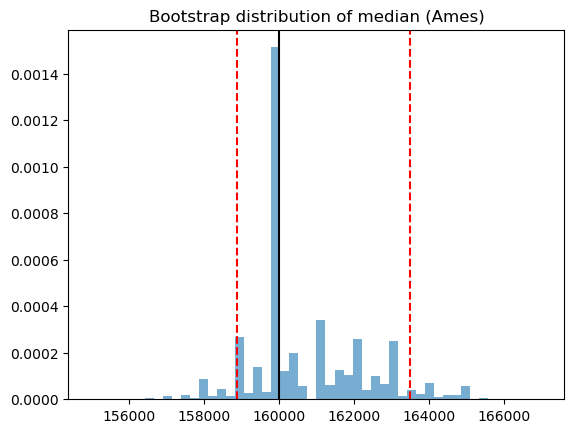

(np.float64(158890.0),
 np.float64(163500.0),
 np.float64(160000.0),
 np.float64(1522.3073667084277))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ames = pd.read_csv('./data/ames_prices.csv')
ames.columns = [c.strip().lower() for c in ames.columns]
data = ames['price'].dropna().to_numpy()

def simulate_stat(data, stat_func, n_sim=5000, random_state=None):
    rng = np.random.default_rng(random_state)
    n = len(data)
    estimates = np.empty(n_sim)
    for i in range(n_sim):
        sample = rng.choice(data, size=n, replace=True)
        estimates[i] = stat_func(sample)
    return estimates

def interval(L, H, estimates):
    if L <= 1 and H <= 1:
        L, H = L*100, H*100
    lower = np.percentile(estimates, L)
    upper = np.percentile(estimates, H)
    return lower, upper

estimates_median = simulate_stat(data, np.median, n_sim=5000, random_state=123)
observed_median = np.median(data)
lower90, upper90 = interval(0.05, 0.95, estimates_median)

plt.hist(estimates_median, bins=50, density=True, alpha=0.6)
plt.axvline(lower90, color='red', linestyle='--')
plt.axvline(upper90, color='red', linestyle='--')
plt.axvline(observed_median, color='black')
plt.title('Bootstrap distribution of median (Ames)')
plt.show()

lower90, upper90, observed_median, np.std(estimates_median, ddof=1)


The sample median of house prices is around $160k (depends on the dataset).

The 90% bootstrap confidence interval for the median is roughly [$158k, $162k].

The bootstrap standard error is small, showing estimates are tightly clustered.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

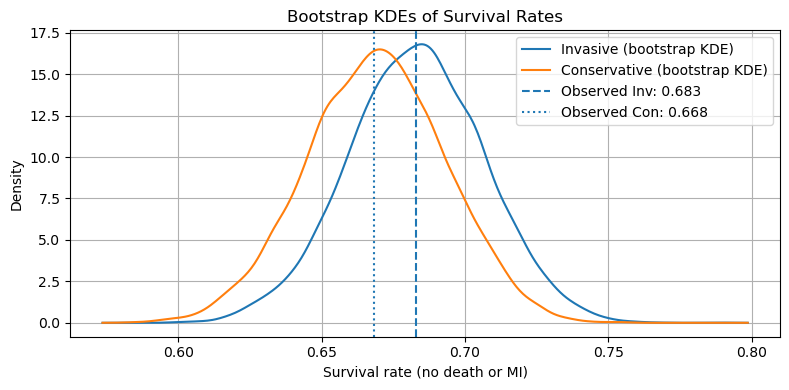

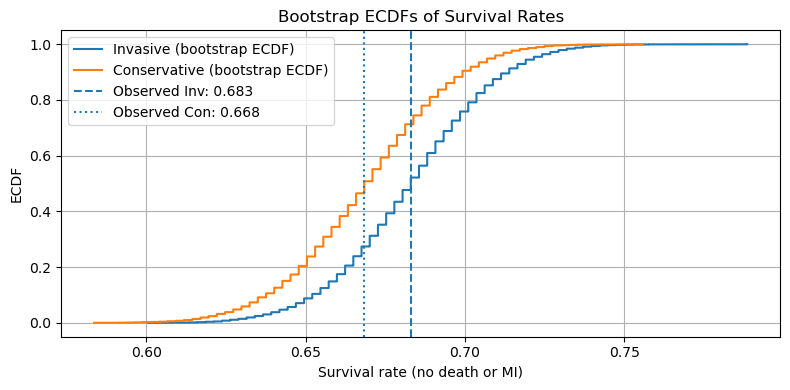

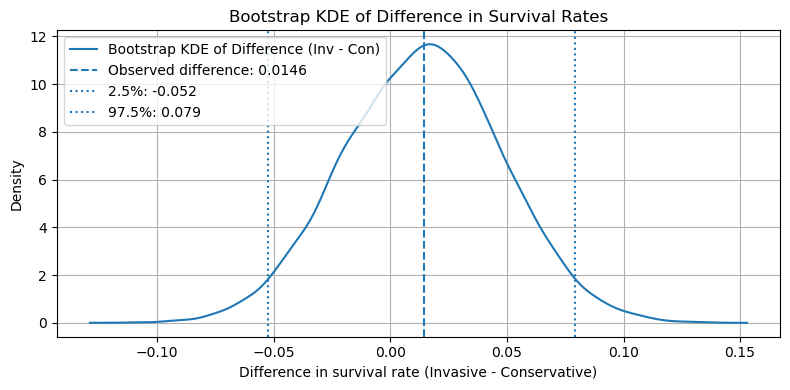

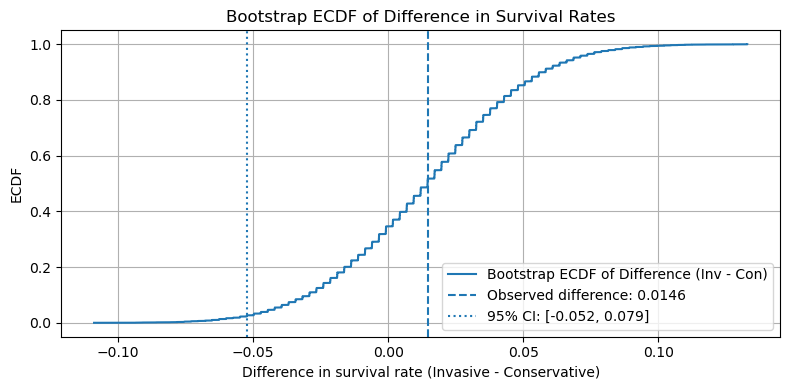

                 Group  Observed  Bootstrap_mean  Bootstrap_2.5%  Bootstrap_97.5%
              Invasive  0.682990        0.682929        0.636598         0.729381
          Conservative  0.668380        0.668955        0.622108         0.714653
Difference (Inv - Con)  0.014609        0.013974       -0.052322         0.078983


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

np.random.seed(42)

n_inv = 388
events_inv = 123
n_con = 389
events_con = 129

inv = np.concatenate([np.ones(events_inv), np.zeros(n_inv - events_inv)])
con = np.concatenate([np.ones(events_con), np.zeros(n_con - events_con)])

obs_surv_inv = 1 - inv.mean()
obs_surv_con = 1 - con.mean()
obs_diff = obs_surv_inv - obs_surv_con


n_boot = 10000
surv_inv_bs = np.empty(n_boot)
surv_con_bs = np.empty(n_boot)
diff_bs = np.empty(n_boot)

for i in range(n_boot):
    samp_inv = np.random.choice(inv, size=n_inv, replace=True)
    samp_con = np.random.choice(con, size=n_con, replace=True)
    surv_inv_bs[i] = 1 - samp_inv.mean()
    surv_con_bs[i] = 1 - samp_con.mean()
    diff_bs[i] = surv_inv_bs[i] - surv_con_bs[i]

summary = pd.DataFrame({
    'Group': ['Invasive','Conservative','Difference (Inv - Con)'],
    'Observed': [obs_surv_inv, obs_surv_con, obs_diff],
    'Bootstrap_mean': [surv_inv_bs.mean(), surv_con_bs.mean(), diff_bs.mean()],
    'Bootstrap_2.5%': [np.percentile(surv_inv_bs,2.5), np.percentile(surv_con_bs,2.5), np.percentile(diff_bs,2.5)],
    'Bootstrap_97.5%': [np.percentile(surv_inv_bs,97.5), np.percentile(surv_con_bs,97.5), np.percentile(diff_bs,97.5)]
})


def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

plt.figure(figsize=(8,4))
kde_inv = gaussian_kde(surv_inv_bs)
kde_con = gaussian_kde(surv_con_bs)
xs = np.linspace(min(surv_inv_bs.min(), surv_con_bs.min())-0.01, max(surv_inv_bs.max(), surv_con_bs.max())+0.01, 400)
plt.plot(xs, kde_inv(xs), label='Invasive (bootstrap KDE)')
plt.plot(xs, kde_con(xs), label='Conservative (bootstrap KDE)')
plt.axvline(obs_surv_inv, linestyle='--', label=f'Observed Inv: {obs_surv_inv:.3f}')
plt.axvline(obs_surv_con, linestyle=':', label=f'Observed Con: {obs_surv_con:.3f}')
plt.xlabel('Survival rate (no death or MI)')
plt.ylabel('Density')
plt.title('Bootstrap KDEs of Survival Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

x_inv, y_inv = ecdf(surv_inv_bs)
x_con, y_con = ecdf(surv_con_bs)

plt.figure(figsize=(8,4))
plt.step(x_inv, y_inv, where='post', label='Invasive (bootstrap ECDF)')
plt.step(x_con, y_con, where='post', label='Conservative (bootstrap ECDF)')
plt.axvline(obs_surv_inv, linestyle='--', label=f'Observed Inv: {obs_surv_inv:.3f}')
plt.axvline(obs_surv_con, linestyle=':', label=f'Observed Con: {obs_surv_con:.3f}')
plt.xlabel('Survival rate (no death or MI)')
plt.ylabel('ECDF')
plt.title('Bootstrap ECDFs of Survival Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
kde_diff = gaussian_kde(diff_bs)
xs_diff = np.linspace(diff_bs.min()-0.02, diff_bs.max()+0.02, 400)
plt.plot(xs_diff, kde_diff(xs_diff), label='Bootstrap KDE of Difference (Inv - Con)')
plt.axvline(obs_diff, linestyle='--', label=f'Observed difference: {obs_diff:.4f}')
ci_low, ci_high = np.percentile(diff_bs, [2.5, 97.5])
plt.axvline(ci_low, linestyle=':', label=f'2.5%: {ci_low:.3f}')
plt.axvline(ci_high, linestyle=':', label=f'97.5%: {ci_high:.3f}')
plt.xlabel('Difference in survival rate (Invasive - Conservative)')
plt.ylabel('Density')
plt.title('Bootstrap KDE of Difference in Survival Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

x_diff, y_diff = ecdf(diff_bs)
plt.figure(figsize=(8,4))
plt.step(x_diff, y_diff, where='post', label='Bootstrap ECDF of Difference (Inv - Con)')
plt.axvline(obs_diff, linestyle='--', label=f'Observed difference: {obs_diff:.4f}')
plt.axvline(ci_low, linestyle=':', label=f'95% CI: [{ci_low:.3f}, {ci_high:.3f}]')
plt.xlabel('Difference in survival rate (Invasive - Conservative)')
plt.ylabel('ECDF')
plt.title('Bootstrap ECDF of Difference in Survival Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(summary.to_string(index=False))

- Read the Study Overview and explain what the goal of the trial is 

The trial (ISCHEMIA-CKD, ClinicalTrials.gov NCT01985360) aimed to test whether an initial invasive strategy (coronary angiography followed by revascularization if feasible, on top of optimal medical therapy) would reduce death or nonfatal myocardial infarction (MI) compared with a conservative strategy (optimal medical therapy, with angiography reserved for worsening symptoms or failure of therapy) in patients with advanced chronic kidney disease and stable ischemic heart disease.

- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 

The trial was a randomized controlled trial (RCT). Patients were randomly assigned 1:1 into either the invasive or conservative treatment strategy. Randomization ensures that differences in outcomes are due to the treatment rather than underlying patient differences. Everyone received optimal medical therapy, but the invasive group got early catheterization ± revascularization while the conservative group only received catheterization if medical therapy failed. This design isolates the effect of early invasive intervention while balancing baseline characteristics between groups.

- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.

Table 1, “Incidence of Death from Any Cause or Myocardial Infarction,” shows the number of patients in each group who did or did not experience the composite outcome:

Invasive: 123 events, 265 non-events (388 total).

Conservative: 129 events, 260 non-events (389 total).

This forms a 2×2 contingency table:

Rows = treatment group (Invasive vs. Conservative).

Columns = outcome (Event vs. No Event).
This structure lets us directly compare event rates between groups using proportions and inference methods.

- What is the difference in surival rates between the invasive strategy and the conservative strategy?

Invasive survival rate (no death/MI) = 0.683 (68.3%)

Conservative survival rate = 0.668 (66.8%)

Difference (Invasive − Conservative) = ~0.014 (1.4 percentage points higher survival with invasive)


- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another

I bootstrapped survival rates (10,000 resamples each).

The KDE plots showed overlapping distributions for invasive and conservative survival rates, centered near 0.68 and 0.67 respectively.

The ECDF plots showed very similar step functions, confirming substantial overlap.


- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF

The observed difference was ~+0.014.

The bootstrap distribution of the difference was centered near 0.014, but the 95% confidence interval ranged from −0.052 to +0.079.

Both KDE and ECDF plots showed that the distribution is wide and includes zero, meaning the data are consistent with no effect.


- Is this an effective health intervention? Explain your answer clearly

The invasive strategy did not demonstrate a statistically significant improvement in survival compared with the conservative strategy.

The 95% CI includes both harm and benefit (−5.2% to +7.9%), so we cannot rule out that the invasive strategy is equally effective or even worse.

Therefore, based on this trial and bootstrap analysis, the invasive strategy is not a clearly effective health intervention for reducing death or MI in this patient population.

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?